In [1]:
import pickle
import statistics
import matplotlib.pyplot as plt
import nltk
import pandas as pd

from scipy import stats
from convokit import Corpus, download

In [2]:
wiki_awry_corpus = Corpus(filename=download('conversations-gone-awry-corpus'))
reddit_awry_corpus = Corpus(filename=download("conversations-gone-awry-cmv-corpus"))
wiki_reg_corpus = Corpus(filename=download('wiki-corpus'))
reddit_reg_corpus = Corpus(filename=download("reddit-corpus-small"))

Dataset already exists at /Users/administrator/.convokit/downloads/conversations-gone-awry-corpus
Dataset already exists at /Users/administrator/.convokit/downloads/conversations-gone-awry-cmv-corpus
Dataset already exists at /Users/administrator/.convokit/downloads/wiki-corpus
Dataset already exists at /Users/administrator/.convokit/downloads/reddit-corpus-small


In [3]:
with open('full_results_reddit_args.pkl', 'rb') as handle:
    reddit_results = pickle.load(handle)
    
with open('full_results_wiki_args.pkl', 'rb') as handle:
    wikipedia_results = pickle.load(handle)
    
with open('full_results_reddit_reg.pkl', 'rb') as handle:
    reddit_reg_results = pickle.load(handle)
    
with open('full_results_wiki_reg.pkl', 'rb') as handle:
    wikipedia_reg_results = pickle.load(handle)

In [4]:
def get_values(results, key):
    return [r[key] for r in results]

def agg_asym(results):
    return get_values(results, 'mean_C_b_a') + get_values(results, 'mean_C_a_b')

In [5]:
reddit_lsms = get_values(reddit_results, 'mean_LSM')
wikipedia_lsms = get_values(wikipedia_results, 'mean_LSM')
reddit_reg_lsms = get_values(reddit_reg_results, 'mean_LSM')
wikipedia_reg_lsms = get_values(wikipedia_reg_results, 'mean_LSM')

all_reddit_symm = reddit_lsms + reddit_reg_lsms
all_wikipedia_symm = wikipedia_lsms + wikipedia_reg_lsms
all_awry_symm = reddit_lsms + wikipedia_lsms
all_reg_symm = reddit_reg_lsms + wikipedia_reg_lsms

In [6]:
reddit_asym = agg_asym(reddit_results)
wikipedia_asym = agg_asym(wikipedia_results)
reddit_reg_asym = agg_asym(reddit_reg_results)
wikipedia_reg_asym = agg_asym(wikipedia_reg_results)

all_reddit_asym = reddit_asym + reddit_reg_asym
all_wikipedia_asym = wikipedia_asym + wikipedia_reg_asym
all_awry_asym = reddit_asym + wikipedia_asym
all_reg_asym = reddit_reg_asym + wikipedia_reg_asym

In [7]:
def lsm_stats(lsms):
    d = {}
    d['min'] = min(lsms)
    d['max'] = max(lsms)
    d['mean'] = statistics.mean(lsms)
    d['median'] = statistics.median(lsms)
    d['variance'] = statistics.variance(lsms)
    print(d)
    plt.hist(lsms)
    plt.show()
    
def compare(x, y):
    lsm_stats(x)
    lsm_stats(y)
    print(stats.ttest_ind(x, y, equal_var=False))

# Symmetric: Reddit vs. Wikipedia

{'min': 0, 'max': 1.0, 'mean': 0.8494764356751682, 'median': 0.853590108073333, 'variance': 0.008029112570727161}


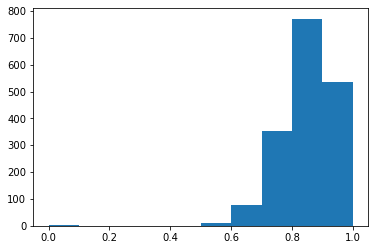

{'min': 0, 'max': 1.0, 'mean': 0.8318004968509434, 'median': 0.8349572093010975, 'variance': 0.014305376573612538}


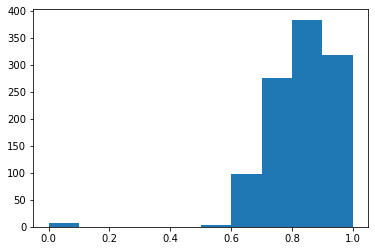

Ttest_indResult(statistic=4.193623801926078, pvalue=2.8761330058070445e-05)


In [8]:
compare(all_reddit_symm, all_wikipedia_symm)

# Symmetric: Awry vs. Reg

{'min': 0, 'max': 1.0, 'mean': 0.8516914652663984, 'median': 0.8571476188888943, 'variance': 0.009567384774720009}


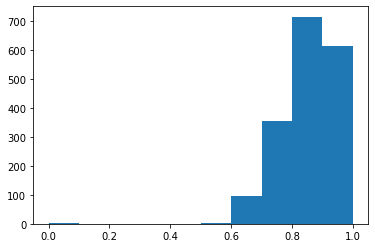

{'min': 0, 'max': 1.0, 'mean': 0.8272915960856947, 'median': 0.8333388887037099, 'variance': 0.011743859630845862}


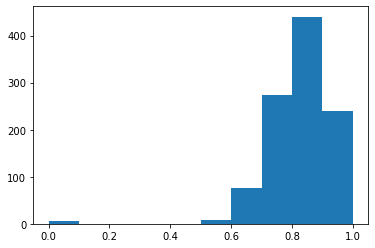

Ttest_indResult(statistic=5.989828264616234, pvalue=2.483236203427924e-09)


In [9]:
compare(all_awry_symm, all_reg_symm)

# ANOVA

In [10]:
df1 = pd.DataFrame(reddit_lsms, columns=["LSM"])
df1['corpus'] = 'reddit'
df1['awry'] = 'True'

df2 = pd.DataFrame(reddit_reg_lsms, columns=["LSM"])
df2['corpus'] = 'reddit'
df2['awry'] = 'False'

df3 = pd.DataFrame(wikipedia_lsms, columns=["LSM"])
df3['corpus'] = 'wikipedia'
df3['awry'] = 'True'

df4 = pd.DataFrame(wikipedia_reg_lsms, columns=["LSM"])
df4['corpus'] = 'wikipedia'
df4['awry'] = 'False'

df = pd.concat([df1, df2, df3, df4])
df

,LSM,corpus,awry
0,0.832471,reddit,True
1,0.830306,reddit,True
2,0.846203,reddit,True
3,0.846670,reddit,True
4,0.962964,reddit,True
...,...,...,...
506,0.800005,wikipedia,False
507,0.952383,wikipedia,False
508,0.733342,wikipedia,False
509,0.933336,wikipedia,False


In [11]:
# https://www.statology.org/two-way-anova-python/ 
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA
model = ols('LSM ~ C(corpus) + C(awry) + C(corpus):C(awry)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(corpus),0.128101,1.0,12.838282,3.453271e-04
C(awry),0.311397,1.0,31.208250,2.538157e-08
C(corpus):C(awry),0.998941,1.0,100.113960,3.476915e-23
Residual,28.237855,2830.0,NaN,NaN


In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df['combination'] = df.corpus + " / " + df.awry

# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df['LSM'], groups=df['combination'], alpha=0.05)

# coerce the tukeyhsd table to a DataFrame
tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])

group1_comp =tukey_data.loc[tukey_data.reject == True].groupby('group1').reject.count()
group2_comp = tukey_data.loc[tukey_data.reject == True].groupby('group2').reject.count()
tukey_data = pd.concat([group1_comp, group2_comp], axis=1)

tukey_data = tukey_data.fillna(0)
tukey_data.columns = ['reject1', 'reject2']
tukey_data['total_sum'] = tukey_data.reject1 + tukey_data.reject2
tukey_data

,reject1,reject2,total_sum
reddit / False,2.0,0.0,2.0
reddit / True,2.0,1.0,3.0
wikipedia / False,1.0,2.0,3.0
wikipedia / True,0.0,2.0,2.0


# Asymmetric: Reddit vs. Wikipedia

{'min': 0.0, 'max': 0.7142857142857143, 'mean': 0.12219178756204475, 'median': 0.1, 'variance': 0.011111254896946731}


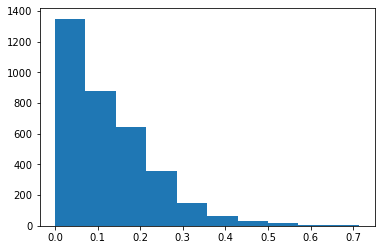

{'min': 0.0, 'max': 1.0, 'mean': 0.12443240863648322, 'median': 0.08333333333333333, 'variance': 0.021692918868906206}


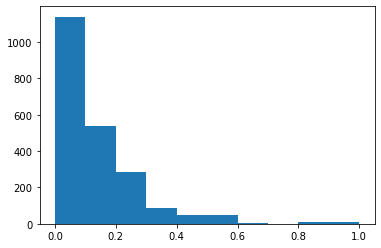

Ttest_indResult(statistic=-0.6175109358348979, pvalue=0.5369373845351009)


In [13]:
compare(all_reddit_asym, all_wikipedia_asym)

# Asymmetric: Awry vs. Reg

{'min': 0.0, 'max': 1.0, 'mean': 0.10504618595505467, 'median': 0.07142857142857142, 'variance': 0.013587797286485785}


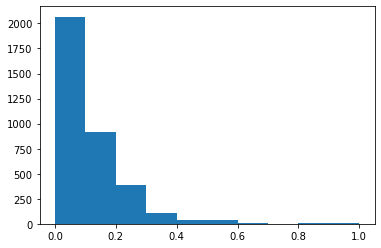

{'min': 0.0, 'max': 1.0, 'mean': 0.1539197007453325, 'median': 0.1388888888888889, 'variance': 0.016365603697946828}


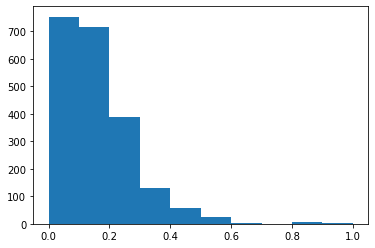

Ttest_indResult(statistic=-14.329139589439384, pvalue=1.8347075806471918e-45)


In [14]:
compare(all_awry_asym, all_reg_asym)

# Symmetric: Has Removed vs No Removed Comments (Reddit Awry)

In [15]:
has_removed = []
no_removed = []
for r in reddit_results:
    convo = reddit_awry_corpus.get_conversation(r['convID'])
    if convo.retrieve_meta('has_removed_comment'):
        has_removed.append(r['mean_LSM'])
    else:
        no_removed.append(r['mean_LSM'])

{'min': 0, 'max': 1.0, 'mean': 0.8678546852638526, 'median': 0.8750041665277823, 'variance': 0.007532233528816973}


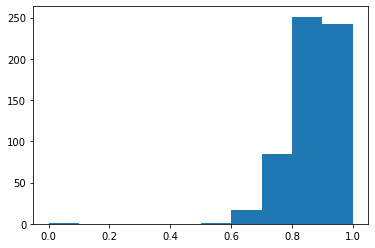

{'min': 0.5000124996875077, 'max': 1.0, 'mean': 0.8651629615735764, 'median': 0.8688339452088676, 'variance': 0.006138096321126589}


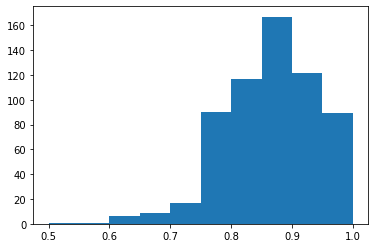

Ttest_indResult(statistic=0.5667838756705991, pvalue=0.5709679304621054)


In [16]:
compare(has_removed, no_removed)

# Symmetric: Has Personal Attack vs. No Attack (Wikipedia Awry)

In [17]:
has_attack = []
no_attack = []
for r in wikipedia_results:
    convo = wiki_awry_corpus.get_conversation(r['convID'])
    if convo.retrieve_meta('conversation_has_personal_attack'):
        has_attack.append(r['mean_LSM'])
    else:
        no_attack.append(r['mean_LSM'])

{'min': 0, 'max': 1.0, 'mean': 0.8158361849452753, 'median': 0.8208377846068666, 'variance': 0.014050165772549335}


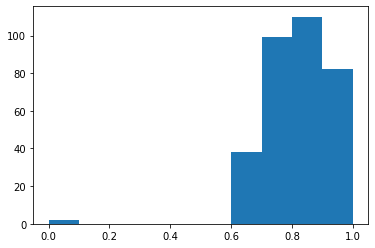

{'min': 0, 'max': 1.0, 'mean': 0.826674917945357, 'median': 0.8333388887037098, 'variance': 0.013819739026392507}


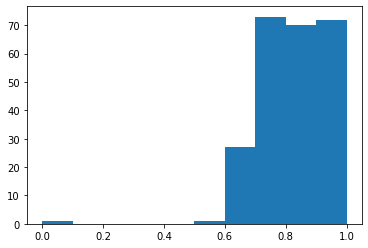

Ttest_indResult(statistic=-1.0888613361873365, pvalue=0.27671354703158435)


In [18]:
compare(has_attack, no_attack)

# Symmetric: Reddit Awry vs Wikipedia Awry

{'min': 0, 'max': 1.0, 'mean': 0.8664833461986008, 'median': 0.8733367554574845, 'variance': 0.00681814042055069}


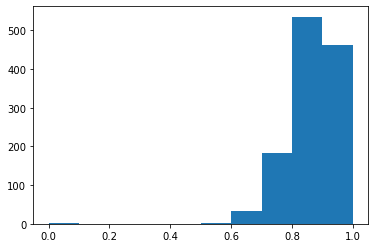

{'min': 0, 'max': 1.0, 'mean': 0.820435577731397, 'median': 0.8291715068027936, 'variance': 0.013956885304473086}


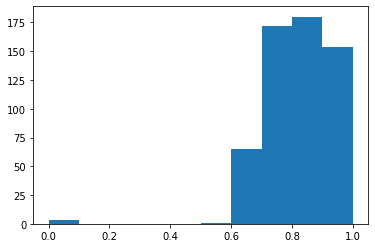

Ttest_indResult(statistic=8.423366957638294, pvalue=1.5519599546029096e-16)


In [19]:
compare(reddit_lsms, wikipedia_lsms)

# Symmetric: Reddit Reg vs. Wikipedia Reg

{'min': 0, 'max': 1.0, 'mean': 0.8107083375776624, 'median': 0.818353543268497, 'variance': 0.008641233241586345}


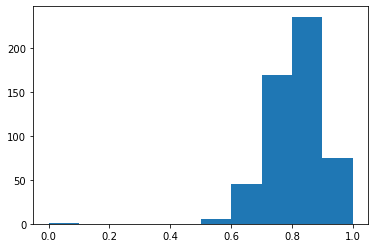

{'min': 0, 'max': 1.0, 'mean': 0.8445888109287107, 'median': 0.8571476188888941, 'variance': 0.014416165060957485}


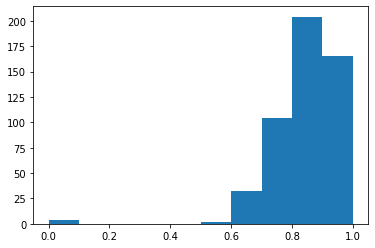

Ttest_indResult(statistic=-5.083233507552061, pvalue=4.4593463550589747e-07)


In [20]:
compare(reddit_reg_lsms, wikipedia_reg_lsms)

# Symmetric: Reddit Reg vs Reddit Awry

{'min': 0, 'max': 1.0, 'mean': 0.8107083375776624, 'median': 0.818353543268497, 'variance': 0.008641233241586345}


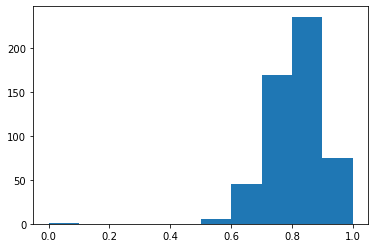

{'min': 0, 'max': 1.0, 'mean': 0.8664833461986008, 'median': 0.8733367554574845, 'variance': 0.00681814042055069}


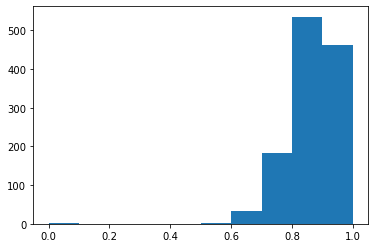

Ttest_indResult(statistic=-11.939101397900892, pvalue=1.2167675784601517e-30)


In [21]:
compare(reddit_reg_lsms, reddit_lsms)

# Symmetric: Wikipedia Reg vs. Wikipedia Awry

{'min': 0, 'max': 1.0, 'mean': 0.8445888109287107, 'median': 0.8571476188888941, 'variance': 0.014416165060957485}


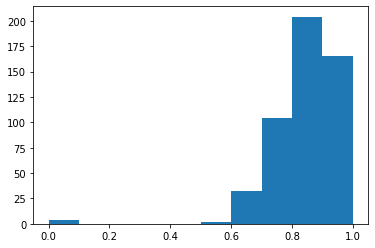

{'min': 0, 'max': 1.0, 'mean': 0.820435577731397, 'median': 0.8291715068027936, 'variance': 0.013956885304473086}


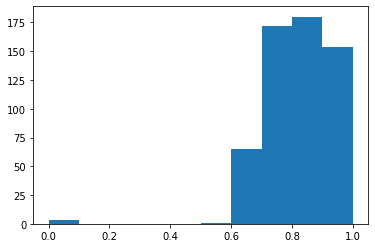

Ttest_indResult(statistic=3.333954516841584, pvalue=0.0008857003317870818)


In [22]:
compare(wikipedia_reg_lsms, wikipedia_lsms)

# Valence (so far only looked at awry corpora)

In [23]:
with open('liwc_dic.pkl', 'rb') as handle:
    liwc = pickle.load(handle)

In [24]:
len(liwc)

607

In [25]:
!wget https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt
afinn_file = "AFINN-en-165.txt"

afinn_dict = {}
with open(afinn_file, encoding="utf8") as file:
    for line in file:
        *word, value = line.split()
        word = ' '.join(word)
        afinn_dict[word] = int(value)

--2021-04-28 13:48:45--  https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt
Resolving raw.githubusercontent.com... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39467 (39K) [text/plain]
Saving to: ‘AFINN-en-165.txt’

AFINN-en-165.txt    100%[===================>]  38.54K  --.-KB/s    in 0.004s  

2021-04-28 13:48:46 (10.6 MB/s) - ‘AFINN-en-165.txt’ saved [39467/39467]



In [26]:
afinns = []
for r in reddit_results:
    convo = reddit_awry_corpus.get_conversation(r['convID'])
    path = convo.get_longest_paths()[0]
    total = 0
    for utt in path:
        words = nltk.word_tokenize(utt.text) 
        afinn = 0
        for word in words:
            word = word.lower()
            afinn += afinn_dict.get(word, 0)
        total += afinn
    afinns.append(total)

(-0.02085020628160327, 0.4677753952242734)


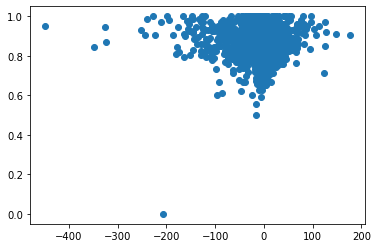

In [27]:
print(stats.pearsonr(afinns, reddit_lsms))
plt.scatter(afinns, reddit_lsms)

In [28]:
afinns = []
for r in wikipedia_results:
    convo = wiki_awry_corpus.get_conversation(r['convID'])
    path = convo.get_longest_paths()[0]
    total = 0
    for utt in path:
        words = nltk.word_tokenize(utt.text) 
        afinn = 0
        for word in words:
            word = word.lower()
            afinn += afinn_dict.get(word, 0)
        total += afinn
    afinns.append(total)

(0.049982286958678915, 0.23143400946355605)


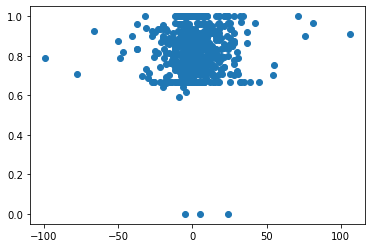

In [29]:
print(stats.pearsonr(afinns, wikipedia_lsms))
plt.scatter(afinns, wikipedia_lsms)

In [30]:
with open('liwc_dic_valence.pkl', 'rb') as handle:
    liwc_valence = pickle.load(handle)

In [31]:
affects = []
for r in reddit_results:
    convo = reddit_awry_corpus.get_conversation(r['convID'])
    path = convo.get_longest_paths()[0]
    total = 0
    for utt in path:
        words = nltk.word_tokenize(utt.text) 
        affect = 0
        for word in words:
            if word in liwc_valence:
                affect += 1
        total += affect
    affects.append(total)

(0.18806272566294754, 3.90682657315824e-11)


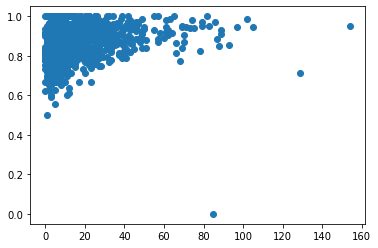

In [32]:
print(stats.pearsonr(affects, reddit_lsms))
plt.scatter(affects, reddit_lsms)

In [33]:
valences1 = []
for r in reddit_results:
    convo = reddit_awry_corpus.get_conversation(r['convID'])
    path = convo.get_longest_paths()[0]
    total = 0
    for utt in path:
        words = nltk.word_tokenize(utt.text) 
        valence = 0
        for word in words:
            if word in liwc_valence:
                if liwc_valence[word] == 'posemo':
                    valence += 1
                elif liwc_valence[word] == 'affect':
                    continue
                else:
                    valence -=1
        total += valence
    valences1.append(total)

(0.1731322210513882, 1.2432753966515423e-09)


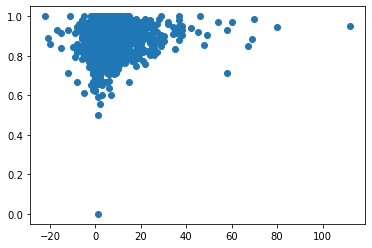

In [34]:
print(stats.pearsonr(valences1, reddit_lsms))
plt.scatter(valences1, reddit_lsms)

In [35]:
affects = []
for r in wikipedia_results:
    convo = wiki_awry_corpus.get_conversation(r['convID'])
    path = convo.get_longest_paths()[0]
    total = 0
    for utt in path:
        words = nltk.word_tokenize(utt.text) 
        affect = 0
        for word in words:
            if word in liwc_valence:
                affect += 1
        total += affect
    affects.append(total)

(0.11547925393412727, 0.0055653226225537665)


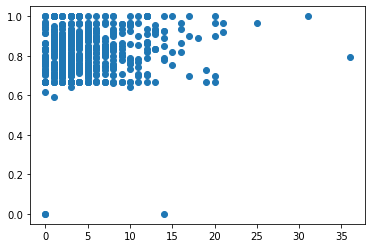

In [36]:
print(stats.pearsonr(affects, wikipedia_lsms))
plt.scatter(affects, wikipedia_lsms)

In [37]:
valences2 = []
for r in wikipedia_results:
    convo = wiki_awry_corpus.get_conversation(r['convID'])
    path = convo.get_longest_paths()[0]
    total = 0
    for utt in path:
        words = nltk.word_tokenize(utt.text) 
        valence = 0
        for word in words:
            if word in liwc_valence:
                if liwc_valence[word] == 'posemo':
                    valence += 1
                elif liwc_valence[word] == 'affect':
                    continue
                else:
                    valence -=1
        total += valence
    valences2.append(total)

(0.08756089251171784, 0.03580804525644762)


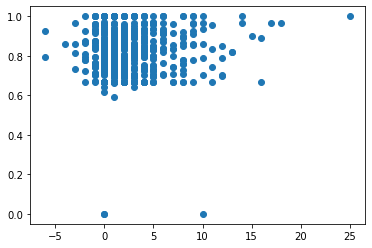

In [38]:
print(stats.pearsonr(valences2, wikipedia_lsms))
plt.scatter(valences2, wikipedia_lsms)

(0.17164476585286242, 2.646394083009808e-13)


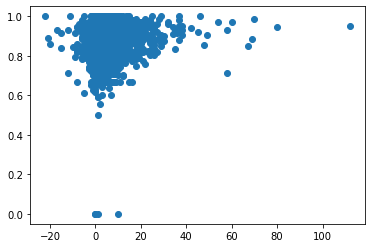

In [39]:
print(stats.pearsonr(valences1 + valences2, reddit_lsms + wikipedia_lsms))
plt.scatter(valences1 + valences2, reddit_lsms + wikipedia_lsms)

In [40]:
wiki_awry_corpus.get_conversation(wikipedia_results[1]['convID'])

Conversation({'obj_type': 'conversation', 'meta': {'page_title': 'User talk:Hrafn', 'page_id': 10374546, 'pair_id': '193565323.8199.8199', 'conversation_has_personal_attack': True, 'verified': True, 'pair_verified': True, 'annotation_year': '2018', 'split': 'train'}, 'vectors': [], 'tree': <convokit.model.utteranceNode.UtteranceNode object at 0x245848580>, 'owner': <convokit.model.corpus.Corpus object at 0x1063d2280>, 'id': '193002106.7341.7341'})